<center> <h2>Projet Finance Quantitative</h2> </center> <br>
<center> <h3>Master 2 MoSEF Data Science - Université Paris 1 Panthéon-Sorbonne</h3> </center> <br>
<center> <h3><b>Genetic Algorithm-optimized Triple Barrier Labeling for Predictive Stock Trading Using GBM Stacking</b></h3> </center> <br>
<center> <h3>Louis LEBRETON</h3> </center> <br>

# Prédiction des labels *buy*, *hold* et *sell*

## Optimisation des modèles GBMs

Dans un premier temps, j'optimise les modèles **XGBoost**, **LGBM**, et **CatBoost** sur un échantillon d'entraînement en utilisant une approche d'optimisation bayésienne. Cette méthode permet d'ajuster efficacement les hyperparamètres pour améliorer les performances des modèles.

## Optimisation du classificateur Softmax

Dans un second temps, j'optimise le métaclassificateur **Softmax** sur un échantillon de validation distinct afin d'éviter le surapprentissage (*overfitting*). Cette étape est également réalisée via une optimisation bayésienne.

## Évaluation du modèle

L’évaluation du modèle a été réalisée à l’aide d’un échantillon de validation. Les performances ont été mesurées à travers plusieurs métriques clés.

## Évaluation des performances

Après avoir prédit les labels buy, hold et sell, je procède à une comparaison de ma stratégie de trading avec d’autres approches plus simples. Les performances des prédictions sont évaluées et comparées à l’aide de plusieurs métriques clés :
- **Profit**
- **Maximum drawdown**
- **Sharpe ratio** 
- **Autres indicateurs pertinents**  

## Stratégies de trading

Les données sont divisées en deux datasets distincts, chacun labellisé pour répondre à une stratégie de trading spécifique :

1. **Stratégie High Risk, High Profit**  
   - Objectif : Maximisation de 0.7 * profit - 0.3 * maximum drawdown.

2. **Stratégie Low Risk, Low Profit**  
   - Objectif : Maximisation de 0.3 * profit - 0.7 * maximum drawdown.

## Période d'analyse

Les données utilisées couvrent une période de cinq années, tout en excluant les impacts liés à la pandémie de COVID-19. Les années analysées sont les suivantes : **2018, 2019, 2022, 2023 et 2024**.


In [52]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, ParameterGrid
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization

from services.df_building.get_labels.equity_strategy import EquityStrategy
from services.prediction.GBM_stacking import GBMStacking

#### Choix du profil de risque: High risk High profit ou Low risk Low profit

In [53]:
risk_profile = 'HRHP' # or LRLP

In [54]:
if risk_profile == 'HRHP':
    risk_profile_type_dict = {'weight_p':0.7, 'weight_mdd':0.3} # High risk High profit
else:
    risk_profile_type_dict = {'weight_p':0.3, 'weight_mdd':0.7} # Low risk Low profit

#### Importation des données

Je constitue trois échantillons distincts pour le développement et l’évaluation du modèle :  
- Un **échantillon d'entraînement (train)**, destiné à entraîner les modèles GBMs
- Un **échantillon de validation (valid)**, destiné à entraîner le metaclassifier
- Un **échantillon de test (test)**, destiné à l’évaluation finale des performances du modèle de classification


In [55]:
# importation des données

df_train = pd.read_csv(f"../data/train_{risk_profile}.csv", index_col=0)
df_test = pd.read_csv(f"../data/test_{risk_profile}.csv", index_col=0)

# temporaire ===========================================================================================================
df_train = pd.concat([df_train] * 10, ignore_index=True)
df_test = pd.concat([df_test] * 10, ignore_index=True)

df_train, df_valid = train_test_split(df_train, test_size=0.2, shuffle=True, random_state=1111)

# renommage label bail de -1 à 2 pour être compatible avec le modèle
df_train[df_train['label'] == -1]  = 2
df_test[df_test['label'] == -1]  = 2
df_valid[df_valid['label'] == -1]  = 2

X_train, X_valid, X_test = df_train.drop(columns=['label']), df_valid.drop(columns=['label']), df_test.drop(columns=['label'])
y_train, y_valid, y_test = df_train['label'].copy(), df_valid['label'].copy(), df_test['label'].copy()

In [56]:
X_train.dropna(axis=1, inplace=True) # temporaire =================================================================
X_valid.dropna(axis=1, inplace=True)
X_test.dropna(axis=1, inplace=True)

# Prédiction des labels

3 classes à prédire

### Optimisation des GBMs

J’optimise les modèles GBM individuellement à l’aide d’une optimisation bayésienne combinée à une validation croisée. L’objectif principal est de maximiser la moyenne de l’AUC calculée sur les différents folds de la validation croisée.

#### Optimisation du XGBoost

In [57]:
def xgb_evaluate(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree):
    """
    evaluation d'un xgboost
    """
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    num_classes = len(np.unique(y_train))

    # modèle avec les hyperparamètres
    model = XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        gamma=gamma,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective='multi:softprob',
        num_class = num_classes,
        random_state=111
    )
    
    # cross val -> score
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc_ovr')
    return np.mean(scores)

In [58]:
param_bounds = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 300),
    'gamma': (0, 5),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1),
}


xgb_optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds=param_bounds,
    random_state=111,
    verbose=2,
)


xgb_optimizer.maximize(init_points=5, n_iter=25)

print("meilleurs hyperparamètres trouvés:")
print(xgb_optimizer.max)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------
| 1         | 1.0       | 0.8061    | 0.8453    | 0.1365    | 8.385     | 3.658     | 87.29     | 0.5112    |
| 2         | 1.0       | 0.7101    | 1.193     | 0.1079    | 9.935     | 3.14      | 70.3      | 0.8348    |
| 3         | 1.0       | 0.8106    | 1.371     | 0.1452    | 3.829     | 1.666     | 275.2     | 0.897     |
| 4         | 0.9973    | 0.9203    | 4.076     | 0.2974    | 7.041     | 8.324     | 155.3     | 0.5137    |
| 5         | 1.0       | 0.7271    | 0.5266    | 0.247     | 7.884     | 6.088     | 118.6     | 0.9992    |
| 6         | 0.9987    | 0.6238    | 3.34      | 0.1017    | 8.905     | 9.953     | 240.9     | 0.8629    |
| 7         | 0.9997    | 0.9746    | 0.7938    | 0.02219   | 9.762     | 3.27      | 86.59     | 0.6374    |
| 8       

#### Optimisation du LightGBM

In [59]:
def lgbm_evaluate(num_leaves, max_depth, learning_rate, n_estimators, min_child_weight, subsample, colsample_bytree):
    """
    evaluation d'un lgbm
    """
    num_leaves = int(num_leaves)
    max_depth = int(max_depth)
    n_estimators = int(n_estimators)
    
    # modèle avec les hyperparamètres
    model = LGBMClassifier(
        num_leaves=num_leaves,
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=111
    )
    
    # cross val -> score
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc_ovr')

    return np.mean(scores)

In [60]:
lgbm_param_bounds = {
    'num_leaves': (20, 100),
    'max_depth': (3, 15),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 300),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1),
}


lgbm_optimizer = BayesianOptimization(
    f=lgbm_evaluate,
    pbounds=lgbm_param_bounds,
    random_state=111,
    verbose=0
)


lgbm_optimizer.maximize(init_points=5, n_iter=25)


print("meilleurs hyperparamètres lgbm trouvés:")
print(lgbm_optimizer.max)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1415
[LightGBM] [Info] Number of data points in the train set: 426, number of used features: 25
[LightGBM] [Info] Start training from score -0.991844
[LightGBM] [Info] Start training from score -0.573800
[LightGBM] [Info] Start training from score -2.722235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

#### Optimisation du Catboost

In [61]:
def catboost_evaluate(depth, learning_rate, iterations, l2_leaf_reg):
    """
    evaluation d'un catboost
    """
  
    depth = int(depth)
    iterations = int(iterations)
    
    # modèle avec les hyperparamètres
    model = CatBoostClassifier(
        depth=depth,
        learning_rate=learning_rate,
        iterations=iterations,
        l2_leaf_reg=l2_leaf_reg,
        loss_function='MultiClass',
        verbose=0,
        random_state=111
    )
    
    # cross val -> score
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='roc_auc_ovr')

    return np.mean(scores)

In [62]:
catboost_param_bounds = {
    'depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'iterations': (50, 300),
    'l2_leaf_reg': (1, 10)
}

catboost_optimizer = BayesianOptimization(
    f=catboost_evaluate,
    pbounds=catboost_param_bounds,
    random_state=111,
    verbose=2
)

catboost_optimizer.maximize(init_points=5, n_iter=10)


print("meilleurs hyperparamètres catboost trouvés:")
print(catboost_optimizer.max)

|   iter    |  target   |   depth   | iterat... | l2_lea... | learni... |
-------------------------------------------------------------------------
| 1         | 1.0       | 7.285     | 92.27     | 4.925     | 0.2331    |
| 2         | 1.0       | 5.067     | 87.29     | 1.202     | 0.1319    |
| 3         | 1.0       | 4.671     | 134.4     | 9.916     | 0.07894   |
| 4         | 1.0       | 3.568     | 217.4     | 6.591     | 0.08953   |
| 5         | 1.0       | 6.264     | 79.59     | 1.666     | 0.2712    |
| 6         | 1.0       | 7.623     | 299.9     | 1.294     | 0.05002   |
| 7         | 1.0       | 9.121     | 299.8     | 9.544     | 0.24      |
| 8         | 1.0       | 4.919     | 299.9     | 2.371     | 0.01398   |
| 9         | 1.0       | 8.436     | 50.22     | 9.854     | 0.1023    |
| 10        | 1.0       | 9.204     | 258.7     | 5.052     | 0.2398    |
| 11        | 1.0       | 9.005     | 175.5     | 1.316     | 0.1238    |
| 12        | 1.0       | 9.164     | 

Récupération des hyperparamètres de GBMs

In [71]:
catboost_params = catboost_optimizer.max['params']
lgbm_params = lgbm_optimizer.max['params']
xgb_params = xgb_optimizer.max['params']

xgb_params['max_depth'] = int(xgb_params['max_depth'])
xgb_params['n_estimators'] = int(xgb_params['n_estimators'])
lgbm_params['num_leaves'] = int(lgbm_params['num_leaves'])
lgbm_params['max_depth'] = int(lgbm_params['max_depth'])
lgbm_params['n_estimators'] = int(lgbm_params['n_estimators'])
catboost_params['iterations']= int(catboost_params['iterations'])
catboost_params['depth']= int(catboost_params['depth'])


### Optimisation du Metaclassifier

J’optimise à présent la régression logistique qui joue le rôle de métaclassificateur dans le cadre du stacking. Cette optimisation repose encore une fois sur une validation croisée et une optimisation bayésienne, avec pour objectif de maximiser la moyenne de l’AUC sur les différents folds.

In [72]:
def metaclassifier_evaluate(C, max_iter):
    """
    evaluation d'un catboost
    """
    max_iter = int(max_iter)

    gbm_stacking_model = GBMStacking(models_to_use=('catboost', 'lightgbm', 'xgboost'),
                                catboost_parameters=catboost_params,
                                lightgbm_parameters=lgbm_params,
                                xgboost_parameters=xgb_params,
                            logistic_regression_parameters={'C': C, 'max_iter': max_iter})
    gbm_stacking_model.fit(X_valid, y_valid)

    # cross val -> score
    scores = cross_val_score(gbm_stacking_model, X_valid, y_valid, cv=3, scoring='roc_auc_ovr')

    return np.mean(scores)

In [73]:
metaclassifier_param_bounds = {
    'C': (0.01, 10),
    'max_iter': (50, 500)
}


metaclassifier_optimizer = BayesianOptimization(
    f=metaclassifier_evaluate,
    pbounds=metaclassifier_param_bounds,
    random_state=111,
    verbose=0
)

metaclassifier_optimizer.maximize(init_points=5, n_iter=25)

print("meilleurs hyperparamètres metaclassifier trouvés :")
print(metaclassifier_optimizer.max)

0:	learn: 0.9048110	total: 10.9ms	remaining: 990ms
1:	learn: 0.7623079	total: 15.8ms	remaining: 712ms
2:	learn: 0.6624128	total: 19.9ms	remaining: 591ms
3:	learn: 0.5813215	total: 27.3ms	remaining: 600ms
4:	learn: 0.5244762	total: 31.9ms	remaining: 555ms
5:	learn: 0.4458241	total: 32.8ms	remaining: 470ms
6:	learn: 0.4007779	total: 36.2ms	remaining: 439ms
7:	learn: 0.3547417	total: 39.9ms	remaining: 419ms
8:	learn: 0.3142762	total: 43.5ms	remaining: 401ms
9:	learn: 0.2850055	total: 51.7ms	remaining: 424ms
10:	learn: 0.2594857	total: 57.1ms	remaining: 420ms
11:	learn: 0.2338391	total: 62.7ms	remaining: 418ms
12:	learn: 0.2136190	total: 68.4ms	remaining: 416ms
13:	learn: 0.1960334	total: 75.6ms	remaining: 421ms
14:	learn: 0.1775028	total: 80.1ms	remaining: 411ms
15:	learn: 0.1636362	total: 84.6ms	remaining: 402ms
16:	learn: 0.1561073	total: 93.3ms	remaining: 412ms
17:	learn: 0.1440647	total: 96.8ms	remaining: 398ms
18:	learn: 0.1367927	total: 102ms	remaining: 393ms
19:	learn: 0.1296039	to

### Evaluation de la performance du modèle

J'évalue maintenant la performance de mon modèle de Stacking sur l'échantillon test

In [76]:
metaclassifier_params = metaclassifier_optimizer.max['params']
metaclassifier_params['max_iter'] = int(metaclassifier_params['max_iter'])

gbm_stacking_model = GBMStacking(models_to_use=('catboost', 'lightgbm', 'xgboost'),
                                catboost_parameters=catboost_params,
                                lightgbm_parameters=lgbm_params,
                                xgboost_parameters=xgb_params,
                            logistic_regression_parameters=metaclassifier_params)
gbm_stacking_model.fit(X_test, y_test) # ================================================================= erreur ici
y_test_pred = gbm_stacking_model.predict(X_test)
y_test_proba = gbm_stacking_model.predict_proba(X_test)

0:	learn: 0.8121875	total: 4.88ms	remaining: 444ms
1:	learn: 0.6449761	total: 5.87ms	remaining: 264ms
2:	learn: 0.5112301	total: 6.98ms	remaining: 207ms
3:	learn: 0.4244340	total: 8.55ms	remaining: 188ms
4:	learn: 0.3383432	total: 9.12ms	remaining: 159ms
5:	learn: 0.2862692	total: 10ms	remaining: 144ms
6:	learn: 0.2493064	total: 12.4ms	remaining: 151ms
7:	learn: 0.2082352	total: 13.2ms	remaining: 139ms
8:	learn: 0.1811635	total: 14ms	remaining: 129ms
9:	learn: 0.1533950	total: 14.6ms	remaining: 119ms
10:	learn: 0.1385254	total: 17.2ms	remaining: 126ms
11:	learn: 0.1267759	total: 19.6ms	remaining: 131ms
12:	learn: 0.1133660	total: 20.4ms	remaining: 124ms
13:	learn: 0.1002474	total: 21.1ms	remaining: 118ms
14:	learn: 0.0902608	total: 21.9ms	remaining: 112ms
15:	learn: 0.0819412	total: 23ms	remaining: 109ms
16:	learn: 0.0755723	total: 24.2ms	remaining: 107ms
17:	learn: 0.0694625	total: 25.4ms	remaining: 105ms
18:	learn: 0.0609787	total: 25.8ms	remaining: 99.2ms
19:	learn: 0.0566151	total:

In [79]:
accuracy = accuracy_score(y_test, y_test_pred)
print(f"accuracy : {accuracy:.2f}")
print('-'*100)
f1 = f1_score(y_test, y_test_pred, average='weighted')
print(f"F1 score : {f1:.2f}")
print('-'*100)
conf_matrix = confusion_matrix(y_test, y_test_pred)
print("matrice de confusion :")
print(conf_matrix)
print('-'*100)
report = classification_report(y_test, y_test_pred)
print("rapport de classification :")
print(report)
print('-'*100)
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
auc = roc_auc_score(y_test_binarized, y_test_proba, average='weighted', multi_class='ovr')
print(f"AUC : {auc:.2f}")

accuracy : 1.00
----------------------------------------------------------------------------------------------------
F1 score : 1.00
----------------------------------------------------------------------------------------------------
matrice de confusion :
[[ 50   0   0]
 [  0 140   0]
 [  0   0  10]]
----------------------------------------------------------------------------------------------------
rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00       140
           2       1.00      1.00      1.00        10

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

----------------------------------------------------------------------------------------------------
AUC : 1.00


#### Sauvegarde du modèle

In [80]:
joblib.dump(gbm_stacking_model, f"../models/gbm_stacking_model_{risk_profile}.pkl")
print(f"modèle enregistré dans models/gbm_stacking_model_{risk_profile}.pkl")

modèle enregistré dans models/gbm_stacking_model_HRHP.pkl


## Evaluation de la stratégie de trading

Mon objectif est d’évaluer la performance de la **stratégie de trading fondée sur mes prédictions des labels buy, hold et sell**. Ensuite, je comparerai les métriques de performance obtenues avec celles de :

- La **stratégie de trading basée sur les vrais labels (buy, hold, sell)**
- Une **stratégie de holding**, où le bitcoin est acheté au début de la période et conservé sans être vendu
- Une **stratégie de DCA (Dollar-Cost Averaging)**, dans laquelle du bitcoin est acheté à intervalles réguliers (ici chaque 1er du mois) avec une   quantité de dollars fixe.

Importation des données, du modèle et des paramètres de la Triple barrier method

In [81]:
cash = 100 # on part avec 100 dollars de cash

file_path = f"../data/tbm_parameters_{risk_profile}.json"

with open(file_path, "r") as json_file:
    tbm_parameters = json.load(json_file)

In [82]:
model_path = f"../models/gbm_stacking_model_{risk_profile}.pkl"
# reload du modèle
gbm_stacking_model = joblib.load(model_path)
print(f"modèle models/gbm_stacking_model_{risk_profile}.pkl chargé")

modèle models/gbm_stacking_model_HRHP.pkl chargé


In [83]:
data = pd.read_csv(f"../data/data_{risk_profile}.csv", index_col=0) # data complet dans l'ordre chronologique

Fonction pour afficher la performance d'une stratégie de trading

In [84]:
def evaluate_strategy(equity_strategy, risk_profile:str) -> None:
    """ 
    fonction pour afficher la performance de ma stratégie de trading.
    Args:
        equity_strategy: stratégie choisie
        risk_profile(str): profil de risque
    """
    profit = equity_strategy.calculate_profit()
    mdd = equity_strategy.calculate_maximum_drawdown()
    fitness = equity_strategy.fitness_function(weight_p=risk_profile_type_dict['weight_p'], weight_mdd=risk_profile_type_dict['weight_mdd'])
    # sharpe_ratio = equity_strategy.calculate_sharpe_ratio(risk_free_rate=0.0) ===============================================================
    sharpe_ratio = 1
    print('-'*100,
          '\n Profit:', int(profit),
          '\n Maximum drawdown:', int(mdd),
          '\n',risk_profile,'fitness:', int(fitness), 
          '\n Sharpe ratio:', int(sharpe_ratio),'\n',
          '-'*100)

#### Stratégie de trading basée sur les vrais labels

In [86]:
data.rename(columns={'price': 'target_price'}, inplace=True)
true_labels_equity_strategy = EquityStrategy(df=data, 
                                     buy_number=tbm_parameters['buy_number'], # nombre de BTC à acheter lors d'un achat
                                     sell_number=tbm_parameters['sell_number'], # nombre de BTC à vendre lors d'une vente
                                     cash = cash)

In [87]:
print('True labels TBM strategy')
evaluate_strategy(true_labels_equity_strategy, risk_profile)

True labels TBM strategy
---------------------------------------------------------------------------------------------------- 
 Profit: 138 
 Maximum drawdown: 17 
 HRHP fitness: 91 
 Sharpe ratio: 1 
 ----------------------------------------------------------------------------------------------------


#### Stratégie de trading basée sur les labels prédits par le modèle de Stacking

In [98]:
data[data['label'] == -1]  = 2

# data.dropna(axis=1, inplace=True)
# y_pred = gbm_stacking_model.predict(data.drop(columns=['label']))
# temporaire ==================================================================================

y_pred = gbm_stacking_model.predict(X_test)

In [89]:
# df_trading_strategy = data.copy() ==========================================================
df_tbm_trading_strategy = X_test.copy()
df_tbm_trading_strategy['label'] = y_pred
# renommage du label bail de 2 à -1
df_tbm_trading_strategy[df_tbm_trading_strategy['label'] == 2]  = -1
df_tbm_trading_strategy.rename(columns={'price': 'target_price'}, inplace=True)

In [90]:
predicted_labels_equity_strategy = EquityStrategy(df=df_tbm_trading_strategy, 
                                     buy_number=tbm_parameters['buy_number'], # nombre de BTC à acheter lors d'un achat
                                     sell_number=tbm_parameters['sell_number'], # nombre de BTC à vendre lors d'une vente
                                     cash = cash)


In [91]:
print('Predicted labels TBM strategy')
evaluate_strategy(predicted_labels_equity_strategy, risk_profile)

Predicted labels TBM strategy
---------------------------------------------------------------------------------------------------- 
 Profit: -123 
 Maximum drawdown: 139 
 HRHP fitness: -128 
 Sharpe ratio: 1 
 ----------------------------------------------------------------------------------------------------


#### Stratégie de Holding

In [92]:
df_trading_hold_strategy = df_tbm_trading_strategy.copy()

nb_btc = cash / df_trading_hold_strategy.iloc[0, 0] # nombre de bitcoin à acheter le 1er jour = le max de BTC possible
df_trading_hold_strategy['label'] = [1] + [0] * (len(df_trading_hold_strategy) - 1) # seule action: achat le 1er jour
hold_equity_strategy = EquityStrategy(df=df_trading_hold_strategy, buy_number=nb_btc, sell_number=0, cash=cash)

print('Hold strategy')
evaluate_strategy(hold_equity_strategy, risk_profile)

Hold strategy
---------------------------------------------------------------------------------------------------- 
 Profit: -18 
 Maximum drawdown: 132 
 HRHP fitness: -52 
 Sharpe ratio: 1 
 ----------------------------------------------------------------------------------------------------


#### Stratégie de DCA (Dollars Cost Averaging)

In [93]:
df_dca_strategy = df_tbm_trading_strategy.copy()
# on définit une stratégie où on achète chaque 1er du mois avec une somme de dollars fixe 
df_dca_strategy['dates'] = pd.to_datetime(df_dca_strategy.index)
df_dca_strategy['label'] = (df_dca_strategy['dates'].dt.day == 1).astype(int) # 1er jour du mois

nb_cash_per_month = cash / (df_dca_strategy['label'] == 1).sum() # somme à débourser chaque mois = cash total / nb de 1er du mois
dca_equity_strategy = EquityStrategy(df=df_dca_strategy, dca_strategy=True, dca_cash=nb_cash_per_month, cash=cash)

print('DCA strategy')
evaluate_strategy(dca_equity_strategy, risk_profile)

DCA strategy
---------------------------------------------------------------------------------------------------- 
 Profit: -326111 
 Maximum drawdown: 495178 
 HRHP fitness: -376831 
 Sharpe ratio: 1 
 ----------------------------------------------------------------------------------------------------


#### Comparaison graphique des stratégies de trading

Mon objectif est de visualiser l’évolution de l’equity curve pour les différentes stratégies au fil du temps.

In [100]:
# ajout au dataset des equity curves des stratégies mises en place
df_trading_strategies = pd.concat(
    [df_tbm_trading_strategy.reset_index(drop=True),
     true_labels_equity_strategy.equity_curve.rename('true_labels_equity_curve'),
     predicted_labels_equity_strategy.equity_curve.rename('predicted_labels_equity_curve'),
     hold_equity_strategy.equity_curve.rename('hold_equity_curve'),
     dca_equity_strategy.equity_curve.rename('dca_equity_curve')
     ],
    axis=1
)

df_trading_strategies.index = X_test.index
df_trading_strategies.tail()

target_price    market_cap        volume  increase_volume  \
195  51319.500126  1.007314e+12  2.373364e+10        -0.225005   
196  67938.554129  1.343351e+12  1.653339e+10        -0.218999   
197  44247.415415  8.686721e+11  2.120088e+10         0.237566   
198  69335.425531  1.370964e+12  4.002502e+10        -0.133341   
199  62392.340483  1.233357e+12  3.200866e+10         0.085703   

     increase_market_cap  increase_price    MA7_volume  MA7_market_cap  \
195            -0.011341       -0.010093  2.473441e+10    1.018877e+12   
196             0.013702        0.013733  3.236903e+10    1.330349e+12   
197             0.027536        0.026913  1.673048e+10    8.457041e+11   
198             0.022960        0.022747  4.040647e+10    1.377135e+12   
199             0.036703        0.036501  2.545922e+10    1.221456e+12   

        MA7_price  volume_lag_7  ...   neutral  positive  increase_negative  \
195  51886.114485  3.199187e+10  ...  0.806519  0.190656           0.030778   
196  67312.330044  1.725386e+10  ...  0.443020  0.539918           7.133889   
197  43114.224285  2.219794e+10  ...  0.555969  0.439854           0.165602   
198  69620.990231  6.548778e+10  ...  0.552974  0.443988           0.415676   
199  61794.432074  3.034906e+10  ...  0.893839  0.033661          11.032865   

     increase_neutral  increase_positive  label  true_labels_equity_curve  \
195          0.116923          -0.307131      1                       NaN   
196          1.562746          -0.345580      1                       NaN   
197         -0.332022           1.680394      1                       NaN   
198          5.550814          -0.513939      1                       NaN   
199          0.684769          -0.927367      1                       NaN   

     predicted_labels_equity_curve  hold_equity_curve  dca_equity_curve  
195                     -21.016629          66.870310    -281737.379171  
196                     -24.436045          88.557645    -348190.119848  
197                     -19.561529          57.641465    -253457.991629  
198                     -24.723455          90.380518    -353774.380548  
199                     -23.294896          81.320013    -326011.318583  

[5 rows x 33 columns]

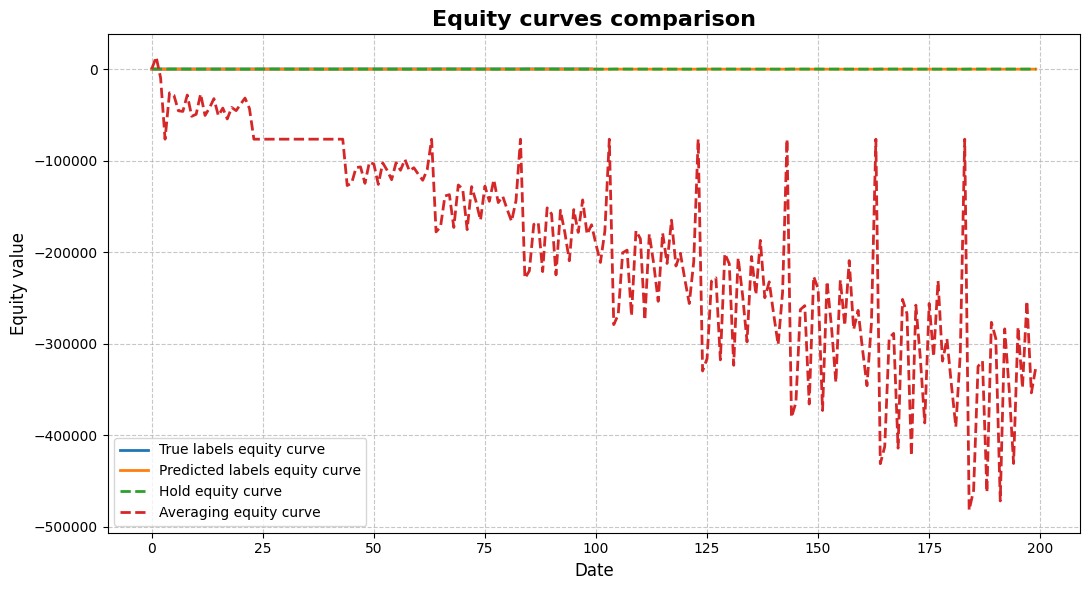

In [96]:
plt.figure(figsize=(11,6))

plt.plot(df_trading_strategies.index, df_trading_strategies['true_labels_equity_curve'], label='True labels equity curve', linewidth=2)
plt.plot(df_trading_strategies.index, df_trading_strategies['predicted_labels_equity_curve'], label='Predicted labels equity curve', linewidth=2)
plt.plot(df_trading_strategies.index, df_trading_strategies['hold_equity_curve'], label='Hold equity curve', linestyle='--', linewidth=2)
plt.plot(df_trading_strategies.index, df_trading_strategies['dca_equity_curve'], label='Averaging equity curve', linestyle='--', linewidth=2)
plt.title("Equity curves comparison", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Equity value", fontsize=12)

plt.legend(loc="best", fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()